In [1]:
import sys
print(sys.version)
# should be 3.6

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


In [2]:
from datetime import datetime
start_time = datetime.now()
print('start_time:', start_time)

start_time: 2020-02-17 09:30:35.092659


# pbi.ai templates
## Predictive Analytics

Welcome!

We created this notebook to provide a practical example of how AI and Data Science can be used when dealing with predictive analytics. It's also a follow up on our article Predictive Analytics which can be found at http://bit.ly/2P2If2s

**Our vision is that Artificial Intelligence isn't just about the code. Also, it's not just about fancy "business talk".**
That's why we combine theory with practical examples wherever it's possible. Our aim is to share knowledge with fellow AI experts, data scientists, machine learning engineers, marketing professionals and business analysts. In other words, all the people who are dealing with the data every day. Don't reinvent the wheel!

Have you been wondering how AI can help improve business? Our articles and tips could help you on your journey :) Visit our blog:
- http://bit.ly/pbiai-blog

Do you have an idea for a new AI product? Have you been thinking about using AI in your company? We can help you with that. You can reach us via our website
- https://www.pbi.ai/

or via social media

- facebook ( https://www.facebook.com/pbiai/ )
- LinkedIn ( https://www.linkedin.com/company/18178189/
- Twitter ( https://twitter.com/pbi_ai ).

Are you from the Czech Republic? Šablona je dostupná také v českém jazyce na http://bit.ly/AI_template_predictions_CZ

Enjoy!


## Template Content
### 1 Data
#### 1.1 Knowledge Representation: Segmentation and Discretization
#### 1.2 Knowledge Representation: Time Series Analysis
#### 1.3 Knowledge Representation: Polynomial Features
### 2 Experiments and AI prototyping
#### 2.1 Future Purchase Prediction (Random Forest)
##### 2.1.1 Preparation of model input
##### 2.1.2 Model training
##### 2.1.3 Model evaluation (testing dataset)
##### 2.1.4 Model evaluation (validation dataset)

## 1 Data

Previously, in our "Return of Experience" template ( http://bit.ly/AI_template_personalization ), we used dummy data similar to real e-commerce data. It was for the transaction history of a fictive e-commerce store. We performed a brief exploratory analysis focused on the relationship between time, transactions, customer features and product features. We will use the same dataset in this template. We will skip the initial analysis to follow the DRY rule (Don't Repeat Yourself) even it's as important as in the last case. Instead, we will focus on **knowledge representation** and **feature engineering**.

Up to 80 % of a Data Science professional's time is spent preparing the data. In particular, **feature engineering** is an activity which basically defines the Data Scientist’s role. The main purpose of feature engineering is to prepare the input for machine learning models. To do it right, one must combine business expertise, tech knowledge and proficiency in applied mathematics/statistics.

There are many ways how to approach feature engineering. We recommend starting with business analysis to reveal the core issues of the problem. At the end of the day we should have a clear idea of what data we need, what data sources should be used, and which variables are worth using for mathematical modeling. We will focus on the **future purchase prediction**. That's why we will do a little magic with the transaction history:
- segmentation and discretization
- time series analysis
- polynomial features

In [3]:
import pandas as pd # basic library for data manipulation

# load purchases
purchases = pd.read_csv("dummy_data_purchases.csv", sep=',')

# parse the timestamp into the datetime object
purchases['timestamp'] = purchases['timestamp'].apply(
    lambda timestamp_string: datetime.strptime(timestamp_string, '%Y-%m-%d %H:%M:%S.%f')
)

FileNotFoundError: [Errno 2] File b'dummy_data_purchases.csv' does not exist: b'dummy_data_purchases.csv'

In [4]:
purchases[:5]

customerid  itemid                  timestamp     price
0       11779   45481 2018-02-17 11:09:09.629588  12783.20
1       15492   45481 2019-02-20 02:01:51.322820  12648.64
2       11480   45481 2018-04-12 07:01:25.615314  13456.00
3       10002   45481 2018-05-09 10:01:18.987823  12244.96
4       16456   45481 2019-02-07 19:01:58.634323  13186.88

In [5]:
import numpy as np # library for the basic mathematical functions
import matplotlib # library for plotting
import matplotlib.pyplot as plt
import seaborn as sns # library for plotting

%matplotlib inline

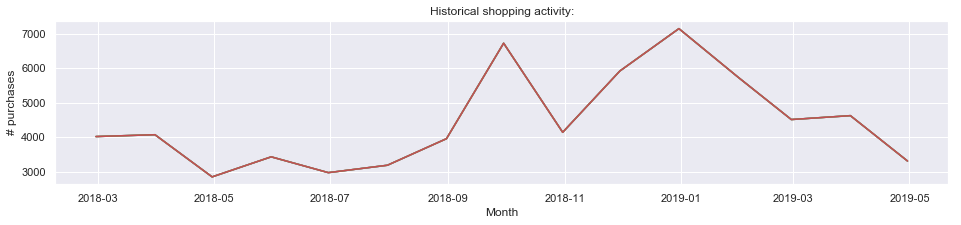

In [6]:
pd.plotting.register_matplotlib_converters() # timeseries converter

# create a new column for the hour of day of the transaction
# - it will be useful in the future computations
purchases['timestamp_hour_of_day'] = purchases['timestamp'].apply(
    lambda timestamp: timestamp.hour
)

sns.set(rc={'figure.figsize':(16, 3)})
plt.figure()
plt.title('Historical shopping activity:')
plt.plot(purchases.set_index('timestamp').resample('M').count())
plt.xlabel('Month')
plt.ylabel('# purchases')
plt.show()

In a real case we would think about **the right period for modeling**. Web and mobile apps are usually being improved continuously. This affects the user experience and possibilities to interact with the customer. During the mathematical modeling, we strive to create simulations that are as real as possible. If the web app has recently undergone big changes, it may be worth excluding older data.

Also, we need to think about the seasonality, weekends vs. workdays and anomalies caused by ad-hoc marketing campaigns. Before modeling, we should consider the whole external context which could significantly affect customer preferences. In this template we use dummy data - that's why we will skip this part. We will do just one thing - we will filter out a period between March and August 2018 due to the low number of transactions.

When predicting the future, we usually analyze particular history to forecast events during a near period in the future. The ideal length of these periods should be determined by the initial business analysis. We should choose a length of time that contains a sufficient amount of data but is relevant to the period we are trying to predict. This could be different for each industry or customer segment. In this template, we will use three months of history to predict purchase in the next month. Let's create these subsets of our data:
- period 1: September-November 2018 (history), December 2018 (future)
- period 2: January-March 2019 (history), April 2019 (future)

Period 1 will be used for model training and testing. We will use the second period for experimenting how the model trained on the autumn data would work during the spring.

In [7]:
from calendar import monthrange

purchases_period1_history = purchases[
    (purchases['timestamp'] >= datetime(2018, 9, 1))
    & (purchases['timestamp'] <= datetime(2018, 11, monthrange(2018, 11)[1]))
]
purchases_period1_future = purchases[
    (purchases['timestamp'] >= datetime(2018, 12, 1))
    & (purchases['timestamp'] <= datetime(2018, 12, monthrange(2018, 12)[1]))
]

purchases_period2_history = purchases[
    (purchases['timestamp'] >= datetime(2019, 1, 1))
    & (purchases['timestamp'] <= datetime(2019, 3, monthrange(2019, 3)[1]))
]
purchases_period2_future = purchases[
    (purchases['timestamp'] >= datetime(2019, 4, 1))
    & (purchases['timestamp'] <= datetime(2019, 4, monthrange(2019, 4)[1]))
]

print('Number of historical transactions:')
print('Period 1 (history):', purchases_period1_history.shape[0])
print('Period 2 (history):', purchases_period2_history.shape[0])

Number of historical transactions:
Period 1 (history): 16550
Period 2 (history): 14764


Let's "pull out" the data about customerids for each period:

In [8]:
customerids_period1_history = set(purchases_period1_history['customerid'])
customerids_period2_history = set(purchases_period2_history['customerid'])

# DataFrame for storing customer features
customers_period1_history = pd.DataFrame({'customerid': list(customerids_period1_history)})
customers_period2_history = pd.DataFrame({'customerid': list(customerids_period2_history)})

print('Number of unique customerids:')
print('Period 1 (history):', len(customerids_period1_history))
print('Period 2 (history):', len(customerids_period2_history))

Number of unique customerids:
Period 1 (history): 8098
Period 2 (history): 7698


### 1.1 Knowledge Representation: Segmentation and Discretization

In general, there are two ways how to approach predictive analysis:
- **classification** – segmenting customers into groups based on future behavior
- **regression** – forecasting the value of particular variables

Sometimes one approach could be converted to the other, for example prediction customer churn:
- Customer features are used to assign a label to each customer based on whether or not he may churn (classification). In other words, we are saying that particular set-up of customer features is correlated with a particular variable (regression). If the value of this variable exceeds some threshold, the customer will churn. The variable could be customer activity or satisfaction, for instance.

This kind of problem conversion is nothing but common sense. Nevertheless, the chosen approach is very important
when it comes to mathematical modeling because it determines how we will work with the **search space**:
- classification – **discrete search space**
- regression – **continuous search space**
We can also combine both approaches into a hybrid model using fuzzy modeling. For instance, we can assign each customer a membership into particular segments. Membership function is usually continuous, segments are discrete.

#### Customer segmentation based on the amount of purchases

We can use similar principles during feature engineering. Each continuous variable can be converted into a categorical variable. We can also combine multiple features to create completely new segments. We can use this technique when working with time or price. We have a price in our dummy data as well. Let's use it to create new customer segments based on the amount of purchases.

For each customer, we can compute new characteristics:
- number of purchases during the particular period
- median of purchases
- standard deviation of the purchase amounts

In [9]:
# aggregate historical data and put the purchase amounts into a new column
customers_period1_history = purchases_period1_history \
    .groupby('customerid')['price'] \
    .apply(list) \
    .reset_index(name='purchases_price_list')

customers_period2_history = purchases_period2_history \
    .groupby('customerid')['price'] \
    .apply(list) \
    .reset_index(name='purchases_price_list')

# create a new column based on number of purchases
customers_period1_history['purchases_count'] = customers_period1_history['purchases_price_list'].apply(len)
customers_period2_history['purchases_count'] = customers_period2_history['purchases_price_list'].apply(len)

# create a new column for the median of purchases amount
customers_period1_history['purchases_median'] = customers_period1_history['purchases_price_list'].apply(np.median)
customers_period2_history['purchases_median'] = customers_period2_history['purchases_price_list'].apply(np.median)

# create a new column for the standard deviation of purchases amount
customers_period1_history['purchases_std'] = customers_period1_history['purchases_price_list'].apply(np.std)
customers_period2_history['purchases_std'] = customers_period2_history['purchases_price_list'].apply(np.std)

# create a new column for the standard deviation of purchases amount in percentage form
# based on the median of purchases amount
customers_period1_history['purchases_std_percentage'] = customers_period1_history.apply(
    lambda customer_history:
        (customer_history['purchases_std']/customer_history['purchases_median'])*100,
    axis=1
)

customers_period2_history['purchases_std_percentage'] = customers_period2_history.apply(
    lambda customer_history:
        (customer_history['purchases_std']/customer_history['purchases_median'])*100,
    axis=1
)

customers_period1_history[:5]

customerid                              purchases_price_list  \
0       10000                                          [5394.0]   
1       10002  [519.75, 17474.940000000002, 10755.84, 18078.65]   
2       10003                [5321.0, 2864.0, 23933.0, 18344.0]   
3       10004                       [18691.25, 16645.5, 6510.0]   
4       10005                    [3575.0, 2922.0, 6907.8, 79.0]   

   purchases_count  purchases_median  purchases_std  purchases_std_percentage  
0                1           5394.00       0.000000                  0.000000  
1                4          14115.39    7069.765256                 50.085511  
2                4          11832.50    8792.084522                 74.304539  
3                3          16645.50    5325.998132                 31.996625  
4                4           3248.50    2428.447819                 74.755974

After the procedure, we have a few new variables: `purchase_count`, `purchase_median`, `purchase_std` and `purchase_std_percentage`. All these variables are continuous and can be used for machine learning. Their range of values is wide, though, and it can be difficult to interpret their relationships. We can make this easier using **discretization**. Let's divide customers into new segments based on the values of these continuous variables. We can start with the `purchase count`:

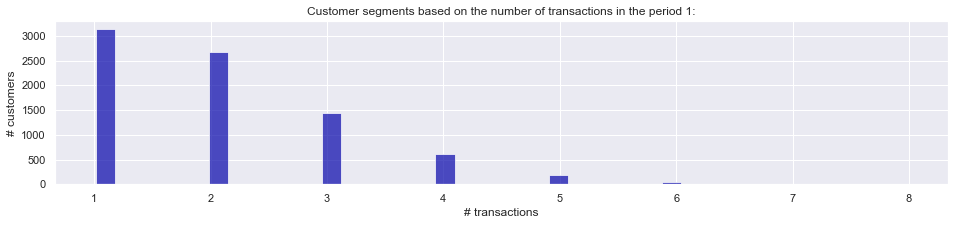

In [10]:
plt.figure()
plt.title('Customer segments based on the number of transactions in the period 1:')
plt.hist(
    x=customers_period1_history['purchases_count'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('# transactions')
plt.ylabel('# customers')
plt.show()

We can use insights about distribution of `purchase_count` values to create a new feature `purchase_count_segment`. For instance, we can split customers into these segments:
- segment 1:  `purchase_count` 1 (new customers)
- segment 2: `purchase_count` 2-5 (occasional customers)
- segment 3: `purchase_count` 6+ (active customers)

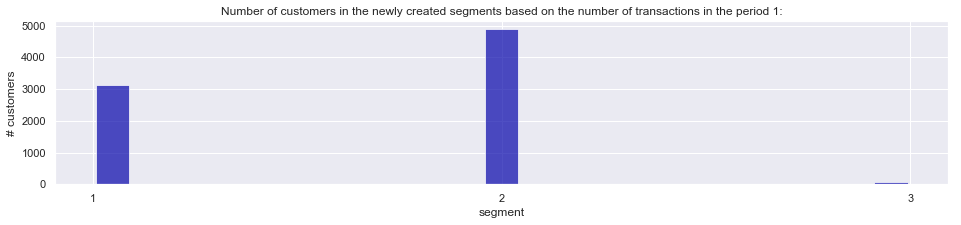

In [11]:
def getPurchaseSegment(purchase_count):
    """
    Returns the customer segment
    based on the number of purchases.
    
    Parameters
    ----------
    purchase_count
        number of purchases
    """
    if purchase_count == 1:
        return 1
    if (purchase_count >= 2) and (purchase_count <= 5):
        return 2
    if purchase_count >= 6:
        return 3
    
    # default segment for the rest of the customers
    return 0
    
# create a new column for the new customer segmentation
customers_period1_history['purchase_count_segment'] = customers_period1_history['purchases_count'] \
    .apply(getPurchaseSegment)
customers_period2_history['purchase_count_segment'] = customers_period2_history['purchases_count'] \
    .apply(getPurchaseSegment)

plt.figure()
plt.title('Number of customers in the newly created segments based on the number of transactions in the period 1:')
plt.hist(
    x=customers_period1_history['purchase_count_segment'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('segment')
plt.ylabel('# customers')
ticks = [1, 2, 3]
labels = [1, 2, 3]
plt.xticks(ticks, labels)
plt.show()

We can use a similar approach with the rest of the variables.

### 1.2 Knowledge Representation: Time Series Analysis

Another parameter we can track is **regularity of purchases** or **preference of time** during the day. If the interaction with customers happens frequently, we can compute a behavioral profile for each customer. This behavioral profile can then be used to customize an offer or marketing campaigns. Also, we can create additional customer segments, for example "early birds" (interactions usually occur early in the morning) or "night owls" (interactions usually occur during the evening).

The only type of interaction we have in our dummy data is purchase history:

In [12]:
# aggregate historical data and put the timestamps into a new column
period1_timestamp = purchases_period1_history \
    .groupby('customerid')['timestamp'] \
    .apply(list) \
    .reset_index(name='purchases_timestamp_list')

period2_timestamp = purchases_period2_history \
    .groupby('customerid')['timestamp'] \
    .apply(list) \
    .reset_index(name='purchases_timestamp_list')

# do the same for the timestamp_hour_of_day column created earlier
period1_timestamp_hour_of_day = purchases_period1_history \
    .groupby('customerid')['timestamp_hour_of_day'] \
    .apply(list) \
    .reset_index(name='purchases_timestamp_hour_of_day_list')

period2_timestamp_hour_of_day = purchases_period2_history \
    .groupby('customerid')['timestamp_hour_of_day'] \
    .apply(list) \
    .reset_index(name='purchases_timestamp_hour_of_day_list')

# add newly created columns into the existing dataframes
customers_period1_history = pd.merge(customers_period1_history, period1_timestamp, on='customerid')
customers_period1_history = pd.merge(customers_period1_history, period1_timestamp_hour_of_day, on='customerid')
customers_period2_history = pd.merge(customers_period2_history, period2_timestamp, on='customerid')
customers_period2_history = pd.merge(customers_period2_history, period2_timestamp_hour_of_day, on='customerid')

customers_period1_history[:5]

customerid                              purchases_price_list  \
0       10000                                          [5394.0]   
1       10002  [519.75, 17474.940000000002, 10755.84, 18078.65]   
2       10003                [5321.0, 2864.0, 23933.0, 18344.0]   
3       10004                       [18691.25, 16645.5, 6510.0]   
4       10005                    [3575.0, 2922.0, 6907.8, 79.0]   

   purchases_count  purchases_median  purchases_std  purchases_std_percentage  \
0                1           5394.00       0.000000                  0.000000   
1                4          14115.39    7069.765256                 50.085511   
2                4          11832.50    8792.084522                 74.304539   
3                3          16645.50    5325.998132                 31.996625   
4                4           3248.50    2428.447819                 74.755974   

   purchase_count_segment                           purchases_timestamp_list  \
0                       1                       [2018-09-15 15:01:37.219186]   
1                       2  [2018-10-23 12:01:40.766790, 2018-09-15 17:01:...   
2                       2  [2018-11-27 22:02:40.424597, 2018-10-01 16:01:...   
3                       2  [2018-11-16 01:02:10.427579, 2018-09-30 00:01:...   
4                       2  [2018-11-05 20:01:47.643444, 2018-09-01 03:01:...   

  purchases_timestamp_hour_of_day_list  
0                                 [15]  
1                     [12, 17, 17, 14]  
2                      [22, 16, 8, 12]  
3                           [1, 0, 11]  
4                      [20, 3, 16, 22]

Now we will create new customer features based on the information about purchases times. We can start with the **favorite hour**. The `purchases_timestamp_hour_of_day_list` column yields a sequence of hours of transactions. We can calculate the median of this sequence for each customer and save the result into a new `favorite_hour` column. After that we can sort customers into new segments and create the new `favorite_hour_segment` feature:
- segment 1: `favorite_hour` 5-9 (early birds)
- segment 2: `favorite_hour` 12-15 (lunch time shoppers)
- segment 3: `favorite_hour` 17-22 (night owls)

In [13]:
# create a new column for the favorite hour
customers_period1_history['favorite_hour'] = customers_period1_history['purchases_timestamp_hour_of_day_list'] \
    .apply(np.median)
customers_period2_history['favorite_hour'] = customers_period2_history['purchases_timestamp_hour_of_day_list'] \
    .apply(np.median)

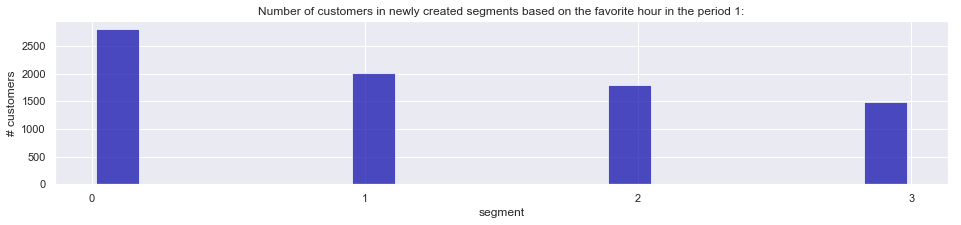

In [14]:
def getFavoriteHourSegment(favorite_hour):
    """
    Returns the customer segment
    based on the favorite hour.
    
    Parameters
    ----------
    favorite_hour
        the favorite hour for shopping
    """
    if (favorite_hour >= 5) and (favorite_hour <= 9):
        return 1
    if (favorite_hour >= 12) and (favorite_hour <= 15):
        return 2
    if (favorite_hour >= 17) and (favorite_hour <= 22):
        return 3
    
    # default segment for the rest of the customers
    return 0

# create a new column for the new segmentation based on the favorite hour
customers_period1_history['favorite_hour_segment'] = customers_period1_history['favorite_hour'] \
    .apply(getFavoriteHourSegment)
customers_period2_history['favorite_hour_segment'] = customers_period2_history['favorite_hour'] \
    .apply(getFavoriteHourSegment)

plt.figure()
plt.title('Number of customers in newly created segments based on the favorite hour in the period 1:')
plt.hist(
    x=customers_period1_history['favorite_hour_segment'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('segment')
plt.ylabel('# customers')
ticks = [0, 1, 2, 3]
labels = [0, 1, 2, 3]
plt.xticks(ticks, labels)
plt.show()

Now we will calculate the **regularity of purchases**. We can base this calculation on time intervals between single transactions. We will calculate the standard deviance between these intervals and if it's reasonably small, we can label such transactions as regular. We will take into account the number of transactions as well. It doesn't make any sense to compute the regularity of purchases for customers which have only made one or two purchases so far.

In [15]:
def getPurchaseIntervals(timestamp_list):
    """
    Calculates intervals between timestamps in seconds.
    
    Parameters
    ----------
    timestamp_list
        list of timestamps
    """
    # ensure that timestamps are in the right order
    timestamp_list_sorted = [timestamp for timestamp in timestamp_list]
    timestamp_list_sorted.sort()
    
    # return the intervals
    return [
        (timestamp_list_sorted[i+1] - timestamp_list_sorted[i]).total_seconds()
        for i in range(len(timestamp_list_sorted) - 1)
    ]

# create a new column for the intervals between purchases
customers_period1_history['purchases_interval_list'] = customers_period1_history['purchases_timestamp_list'] \
    .apply(getPurchaseIntervals)
customers_period2_history['purchases_interval_list'] = customers_period2_history['purchases_timestamp_list'] \
    .apply(getPurchaseIntervals)

# create a new column for the median of the intervals
customers_period1_history['purchases_interval_median'] = customers_period1_history['purchases_interval_list'] \
    .apply(np.median)
customers_period2_history['purchases_interval_median'] = customers_period2_history['purchases_interval_list'] \
    .apply(np.median)

# create a new column for the standard deviation of the intervals
customers_period1_history['purchases_interval_std'] = customers_period1_history['purchases_interval_list'] \
    .apply(np.std)
customers_period2_history['purchases_interval_std'] = customers_period2_history['purchases_interval_list'] \
    .apply(np.std)

# create a new column for the standard deviation of the intervals in percentage form
# based on the median of the intervals
customers_period1_history['purchases_interval_std_percentage'] = customers_period1_history.apply(
    lambda customer_history:
        (customer_history['purchases_interval_std']/customer_history['purchases_interval_median'])*100,
    axis=1
)

customers_period2_history['purchases_interval_std_percentage'] = customers_period2_history.apply(
    lambda customer_history:
        (customer_history['purchases_interval_std']/customer_history['purchases_interval_median'])*100,
    axis=1
)

customers_period1_history[:5]

/home/ondra/.virtualenvs/aiworkshop/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ondra/.virtualenvs/aiworkshop/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


customerid                              purchases_price_list  \
0       10000                                          [5394.0]   
1       10002  [519.75, 17474.940000000002, 10755.84, 18078.65]   
2       10003                [5321.0, 2864.0, 23933.0, 18344.0]   
3       10004                       [18691.25, 16645.5, 6510.0]   
4       10005                    [3575.0, 2922.0, 6907.8, 79.0]   

   purchases_count  purchases_median  purchases_std  purchases_std_percentage  \
0                1           5394.00       0.000000                  0.000000   
1                4          14115.39    7069.765256                 50.085511   
2                4          11832.50    8792.084522                 74.304539   
3                3          16645.50    5325.998132                 31.996625   
4                4           3248.50    2428.447819                 74.755974   

   purchase_count_segment                           purchases_timestamp_list  \
0                       1                       [2018-09-15 15:01:37.219186]   
1                       2  [2018-10-23 12:01:40.766790, 2018-09-15 17:01:...   
2                       2  [2018-11-27 22:02:40.424597, 2018-10-01 16:01:...   
3                       2  [2018-11-16 01:02:10.427579, 2018-09-30 00:01:...   
4                       2  [2018-11-05 20:01:47.643444, 2018-09-01 03:01:...   

  purchases_timestamp_hour_of_day_list  favorite_hour  favorite_hour_segment  \
0                                 [15]           15.0                      2   
1                     [12, 17, 17, 14]           15.5                      0   
2                      [22, 16, 8, 12]           14.0                      2   
3                           [1, 0, 11]            1.0                      0   
4                      [20, 3, 16, 22]           18.0                      3   

                           purchases_interval_list  purchases_interval_median  \
0                                               []                        NaN   
1  [442812.891867, 1382380.975279, 1882827.028315]               1.382381e+06   
2  [2102387.867475, 2491221.39536, 2455258.795617]               2.455259e+06   
3                  [1515574.82993, 4064437.463687]               2.790006e+06   
4  [241200.581704, 5436032.014689, 1713629.232089]               1.713629e+06   

   purchases_interval_std  purchases_interval_std_percentage  
0                     NaN                                NaN  
1            5.969250e+05                          43.180933  
2            1.754368e+05                           7.145350  
3            1.274431e+06                          45.678441  
4            2.186082e+06                         127.570320

Some customers have only made one purchase so far. Thanks to that, we started to have `NaN` values in our dataset because there are no intervals for these customers. In general, we have three options how to deal with this problem:
1. Omission – we can simply filter these customers out of our dataset
2. Imputation – we can use some function to replace the missing values, for instance, the median of the rest of the values
3. Analysis or work around – we can use methods that are not affected by the missing values

In our template we will use the third approach. We will use a new feature instead of using intervals directly. This feature will be called `regular_customer` and we will calculate it using two other columns:
- segment 1: `purchases_count` > 2 and `purchases_interval_std_percentage` < 10 (regular customers; deviation in intervals below 10 % of median)
- segment 0: the rest of the customers

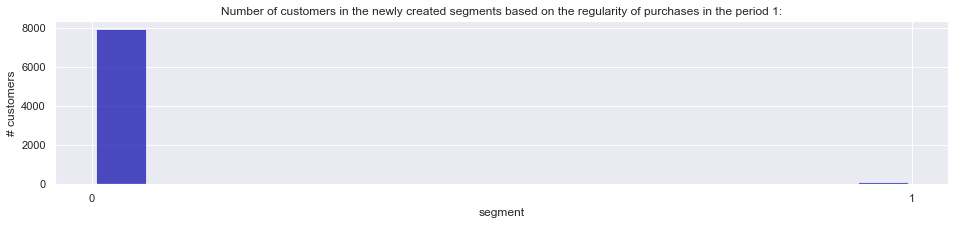

In [16]:
def getRegularCustomer(customer_history):
    """
    Separates regular customers
    from the rest based on
    the number of purchases
    and percentage deviation
    of intervals between purchases.
    
    Parameters
    ----------
    customer_history
        a dataframe row with the customer features
    """
    if (customer_history['purchases_count'] > 2) and (customer_history['purchases_interval_std_percentage'] < 10):
        return 1
    
    # default segment for the rest of customers
    return 0

customers_period1_history['regular_customer'] = customers_period1_history.apply(
    lambda customer_history: getRegularCustomer(customer_history),
    axis=1
)

customers_period2_history['regular_customer'] = customers_period2_history.apply(
    lambda customer_history: getRegularCustomer(customer_history),
    axis=1
)

plt.figure()
plt.title('Number of customers in the newly created segments based on the regularity of purchases in the period 1:')
plt.hist(
    x=customers_period1_history['regular_customer'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85)
plt.xlabel('segment')
plt.ylabel('# customers')
ticks = [0, 1]
labels = [0, 1]
plt.xticks(ticks, labels)
plt.show()

You can try similar procedures with the rest of the variables.

### 1.3 Knowledge Representation: Polynomial Features

We can create new variables by combining the existing ones. For that we can use mathematical functions such as logarithms or square root. In this template we will show how to use polynomials. We will combine a selection of numeric variables and create polynomials up to degree 2: `purchases_count`, `purchases_median` and `purchases_std_percentage`. In the real case we could also use customer features such as age or the size of the city.

In [17]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_feature_selection = [
    'purchases_count',
    'purchases_median',
    'purchases_std_percentage'
]

polynomial_features1 = PolynomialFeatures(degree=2) \
    .fit(customers_period1_history[polynomial_feature_selection])
polynomial_features1_df = pd.DataFrame(
    polynomial_features1.transform(customers_period1_history[polynomial_feature_selection])
)

polynomial_features2 = PolynomialFeatures(degree=2) \
    .fit(customers_period2_history[polynomial_feature_selection])
polynomial_features2_df = pd.DataFrame(
    polynomial_features2.transform(customers_period2_history[polynomial_feature_selection])
)

poly_feature_names = polynomial_features1.get_feature_names()
poly_feature_names

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

We used the `PolynomialFeatures` to create new columns in the following format: `[1, a, b, a^2, ab, b^2]`, `a` and `b` are the original variables used in the operation. To make the future work easier, we will rename these columns for better understanding:

In [18]:
poly_column_names = [
    feature_name \
        .replace('x0', 'purchases_count') \
        .replace('x1', 'purchases_median') \
        .replace('x2', 'purchases_std_percentage') \
        .replace(' ', '*') \
    
    for feature_name in poly_feature_names
]
polynomial_features1_df.columns = poly_column_names
polynomial_features2_df.columns = poly_column_names
polynomial_features1_df[:5]

1  purchases_count  purchases_median  purchases_std_percentage  \
0  1.0              1.0           5394.00                  0.000000   
1  1.0              4.0          14115.39                 50.085511   
2  1.0              4.0          11832.50                 74.304539   
3  1.0              3.0          16645.50                 31.996625   
4  1.0              4.0           3248.50                 74.755974   

   purchases_count^2  purchases_count*purchases_median  \
0                1.0                           5394.00   
1               16.0                          56461.56   
2               16.0                          47330.00   
3                9.0                          49936.50   
4               16.0                          12994.00   

   purchases_count*purchases_std_percentage  purchases_median^2  \
0                                  0.000000        2.909524e+07   
1                                200.342045        1.992442e+08   
2                                297.218154        1.400081e+08   
3                                 95.989874        2.770727e+08   
4                                299.023896        1.055275e+07   

   purchases_median*purchases_std_percentage  purchases_std_percentage^2  
0                                   0.000000                    0.000000  
1                              706976.525647                 2508.558444  
2                              879208.452246                 5521.164447  
3                              532599.813155                 1023.783980  
4                              242844.781857                 5588.455663

Now we can add the newly created features into the original datasets:

In [19]:
# filter columns already presented in the datasets
poly_column_names_selection = list(set(poly_column_names) - set(polynomial_feature_selection))

# add newly created features into the original datasets
customers_period1_history = pd.concat(
    [customers_period1_history, polynomial_features1_df[poly_column_names_selection]],
    axis=1
)
customers_period2_history = pd.concat(
    [customers_period2_history, polynomial_features2_df[poly_column_names_selection]],
    axis=1
)

customers_period1_history[:5]

customerid                              purchases_price_list  \
0       10000                                          [5394.0]   
1       10002  [519.75, 17474.940000000002, 10755.84, 18078.65]   
2       10003                [5321.0, 2864.0, 23933.0, 18344.0]   
3       10004                       [18691.25, 16645.5, 6510.0]   
4       10005                    [3575.0, 2922.0, 6907.8, 79.0]   

   purchases_count  purchases_median  purchases_std  purchases_std_percentage  \
0                1           5394.00       0.000000                  0.000000   
1                4          14115.39    7069.765256                 50.085511   
2                4          11832.50    8792.084522                 74.304539   
3                3          16645.50    5325.998132                 31.996625   
4                4           3248.50    2428.447819                 74.755974   

   purchase_count_segment                           purchases_timestamp_list  \
0                       1                       [2018-09-15 15:01:37.219186]   
1                       2  [2018-10-23 12:01:40.766790, 2018-09-15 17:01:...   
2                       2  [2018-11-27 22:02:40.424597, 2018-10-01 16:01:...   
3                       2  [2018-11-16 01:02:10.427579, 2018-09-30 00:01:...   
4                       2  [2018-11-05 20:01:47.643444, 2018-09-01 03:01:...   

  purchases_timestamp_hour_of_day_list  favorite_hour  ...  \
0                                 [15]           15.0  ...   
1                     [12, 17, 17, 14]           15.5  ...   
2                      [22, 16, 8, 12]           14.0  ...   
3                           [1, 0, 11]            1.0  ...   
4                      [20, 3, 16, 22]           18.0  ...   

   purchases_interval_std purchases_interval_std_percentage  regular_customer  \
0                     NaN                               NaN                 0   
1            5.969250e+05                         43.180933                 0   
2            1.754368e+05                          7.145350                 1   
3            1.274431e+06                         45.678441                 0   
4            2.186082e+06                        127.570320                 0   

   purchases_count^2  purchases_count*purchases_std_percentage  \
0                1.0                                  0.000000   
1               16.0                                200.342045   
2               16.0                                297.218154   
3                9.0                                 95.989874   
4               16.0                                299.023896   

   purchases_count*purchases_median  purchases_median^2    1  \
0                           5394.00        2.909524e+07  1.0   
1                          56461.56        1.992442e+08  1.0   
2                          47330.00        1.400081e+08  1.0   
3                          49936.50        2.770727e+08  1.0   
4                          12994.00        1.055275e+07  1.0   

   purchases_median*purchases_std_percentage  purchases_std_percentage^2  
0                                   0.000000                    0.000000  
1                              706976.525647                 2508.558444  
2                              879208.452246                 5521.164447  
3                              532599.813155                 1023.783980  
4                              242844.781857                 5588.455663  

[5 rows x 23 columns]

## 2 Experiments and AI prototyping

After creating some features, we can begin with experiments. We have already mentioned that one of the use-cases AI can help with is predicting future purchases or customer churn. In both cases we can frame the problem using three categories of information:
1. static customer features (age, location and other demographic properties)
2. dynamic customer features (history of transactions, behavior, favorite products)
3. context (app and GUI version, seasonality, marketing campaigns, competition, the state of the economy)

We have only included a limited amount of information in this template so as not to make it too long.

In the previous template ( http://bit.ly/AI_template_personalization_CZ ) we already analyzed the data. We know that we have static customer features such as location, sex and age. All these properties are represented by categorical columns `locationid`, `sexid` and `agegroupid`.
We computed some dynamic customer features earlier in the previous chapter of this notebook.
Now we have a combination of categorical and numerical features. What we are missing is the context of the data. At the beginning of this template we mentioned that the data we have is actually dummy data (randomly generated values). That's why it does not make sense to bother with the context in this case.

Let's add the static customer features to the existing dataframes:

In [20]:
# load the data about the customers
customers = pd.read_csv("dummy_data_customers.csv", sep=',')

# connect static customer features with the rest of the features
customers_period1_history = pd.merge(customers_period1_history, customers, on='customerid')
customers_period2_history = pd.merge(customers_period2_history, customers, on='customerid')

customers_period1_history[:5]

customerid                              purchases_price_list  \
0       10000                                          [5394.0]   
1       10002  [519.75, 17474.940000000002, 10755.84, 18078.65]   
2       10003                [5321.0, 2864.0, 23933.0, 18344.0]   
3       10004                       [18691.25, 16645.5, 6510.0]   
4       10005                    [3575.0, 2922.0, 6907.8, 79.0]   

   purchases_count  purchases_median  purchases_std  purchases_std_percentage  \
0                1           5394.00       0.000000                  0.000000   
1                4          14115.39    7069.765256                 50.085511   
2                4          11832.50    8792.084522                 74.304539   
3                3          16645.50    5325.998132                 31.996625   
4                4           3248.50    2428.447819                 74.755974   

   purchase_count_segment                           purchases_timestamp_list  \
0                       1                       [2018-09-15 15:01:37.219186]   
1                       2  [2018-10-23 12:01:40.766790, 2018-09-15 17:01:...   
2                       2  [2018-11-27 22:02:40.424597, 2018-10-01 16:01:...   
3                       2  [2018-11-16 01:02:10.427579, 2018-09-30 00:01:...   
4                       2  [2018-11-05 20:01:47.643444, 2018-09-01 03:01:...   

  purchases_timestamp_hour_of_day_list  favorite_hour  ...  purchases_count^2  \
0                                 [15]           15.0  ...                1.0   
1                     [12, 17, 17, 14]           15.5  ...               16.0   
2                      [22, 16, 8, 12]           14.0  ...               16.0   
3                           [1, 0, 11]            1.0  ...                9.0   
4                      [20, 3, 16, 22]           18.0  ...               16.0   

  purchases_count*purchases_std_percentage  purchases_count*purchases_median  \
0                                 0.000000                           5394.00   
1                               200.342045                          56461.56   
2                               297.218154                          47330.00   
3                                95.989874                          49936.50   
4                               299.023896                          12994.00   

   purchases_median^2    1  purchases_median*purchases_std_percentage  \
0        2.909524e+07  1.0                                   0.000000   
1        1.992442e+08  1.0                              706976.525647   
2        1.400081e+08  1.0                              879208.452246   
3        2.770727e+08  1.0                              532599.813155   
4        1.055275e+07  1.0                              242844.781857   

   purchases_std_percentage^2  locationid  agegroupid  sexid  
0                    0.000000           7           0      0  
1                 2508.558444           2           2      0  
2                 5521.164447           5           0      0  
3                 1023.783980           5           0      0  
4                 5588.455663           9           1      0  

[5 rows x 26 columns]

In most cases we think about these properties when **selecting the model** for machine learning:
- data quality, quantity and availability
- number and type of input variables
- type of output variable
- available computational power
- demands for the model interpretability

In our case we are combining categorical and numerical features. It is also useful to know why the model predicts particular output because we can use this information to optimize marketing campaigns. In such case we usually prefer the random forest model.

### 2.1 Future Purchase Prediction (Random Forest)

We have already mentioned the random forest model in our article Opening the Black Box ( http://bit.ly/2m9ACg5 ). It's a system of several decision trees. Each tree gradually divides the training data into branches based on distribution of values and classes.

#### 2.1.1 Preparation of model input

In this template we will use the **scikit-learn** random forest model (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). This model has quite a simple and clear interface; nevertheless, it can only work with numerical features. Fortunately, we can transform our categorical features into numeric ones using a process called **dummification** or **one-hot-encoding**.

We will create a new binary column for each value of a categorical value. The new column will be set to 1 if the categorical variable is equal to the given categorical value on the given row. Otherwise, it will be set to 0. Some of our categorical features meet this condition already - for instance, `sexid`. We can leave these features as they are. To ensure that this template is not too complicated, we will adjust only part of our categorical features.

In [21]:
# selection of categorical features to dummify
columns_to_dummify = [
    'favorite_hour_segment',
    'agegroupid'
]

# create a table for mapping new columns
# to make the future manipulation easier
dummified_columns_mappings = pd.DataFrame(
    {
        'column_name': columns_to_dummify,
        'dummified_column_names': [[] for column in columns_to_dummify]
    }
)

def dummify(column, dataframe):
    """
    Dummifies categorical columns
    in the given dataframe.
    
    Parametry
    ----------
    column
        a row containing specification of column to dummify
        (column name and names of new columns after the dummification)
    dataframe
        Pandas Dataframe with the columns to dummify
    """

    # create dummified columns
    dummified_data = pd.get_dummies(
        dataframe[column['column_name']],
        prefix = column['column_name']
    )
    
    # add newly created columns into the original dataframe
    for dummified_column in dummified_data.columns:
        dataframe[dummified_column] = dummified_data[dummified_column]
        
        # add names of the newly created columns into the mapping table
        # only in case they aren't already here
        dummified_column_names = set(column['dummified_column_names'])
        if dummified_column not in dummified_column_names:
            column['dummified_column_names'].append(dummified_column)

# dummify the datasets
dummified_columns_mappings.apply(
    lambda column: dummify(column, customers_period1_history)
    , axis=1
)
dummified_columns_mappings.apply(
    lambda column: dummify(column, customers_period2_history)
    , axis=1
)

# It is possible that some categorical values
# are not presented in both datasets
# and therefore we may have different columns in our dataframes.
# We can do a quick check - if a column is missing,
# we will add it and set it to 0.
columns_missing_in_df1 = set(customers_period2_history) - set(customers_period1_history)
columns_missing_in_df2 = set(customers_period1_history) - set(customers_period2_history)
for column in columns_missing_in_df1:
    customers_period1_history[column] = 0
for column in columns_missing_in_df2:
    customers_period2_history[column] = 0


# we will re-index the mapping table for easier access
# using just the original column names
dummified_columns_mappings = dummified_columns_mappings.set_index('column_name')
dummified_columns_mappings

dummified_column_names
column_name                                                             
favorite_hour_segment  [favorite_hour_segment_0, favorite_hour_segmen...
agegroupid             [agegroupid_0, agegroupid_1, agegroupid_2, age...

In [22]:
customers_period1_history[
    dummified_columns_mappings.loc['favorite_hour_segment']['dummified_column_names']
][:5]

favorite_hour_segment_0  favorite_hour_segment_1  favorite_hour_segment_2  \
0                        0                        0                        1   
1                        1                        0                        0   
2                        0                        0                        1   
3                        1                        0                        0   
4                        0                        0                        0   

   favorite_hour_segment_3  
0                        0  
1                        0  
2                        0  
3                        0  
4                        1

Now we can do some machine learning!
First, we select features to use in the model. In an ideal scenario, we would select only **mutually independent features** to avoid **false correlations**. It is questionable whether we should use some features together, for example `purchases_median` and `purchases_median^2` or `purchases_count` and `regular_customer`.

In [23]:
customer_static_features = dummified_columns_mappings.loc['agegroupid']['dummified_column_names'] \
    + ['sexid']

customer_dynamic_features = dummified_columns_mappings.loc['favorite_hour_segment']['dummified_column_names'] \
    + poly_column_names \
    + ['regular_customer']

feature_selection = customer_static_features + customer_dynamic_features
feature_selection

['agegroupid_0',
 'agegroupid_1',
 'agegroupid_2',
 'agegroupid_3',
 'agegroupid_4',
 'sexid',
 'favorite_hour_segment_0',
 'favorite_hour_segment_1',
 'favorite_hour_segment_2',
 'favorite_hour_segment_3',
 '1',
 'purchases_count',
 'purchases_median',
 'purchases_std_percentage',
 'purchases_count^2',
 'purchases_count*purchases_median',
 'purchases_count*purchases_std_percentage',
 'purchases_median^2',
 'purchases_median*purchases_std_percentage',
 'purchases_std_percentage^2',
 'regular_customer']

After that we will prepare a **training and testing sample**. We are focusing on the future purchase prediction in our example. The input data will consist of a selection of columns from the last step and the expected output data will consist of 0-1 column indicating whether the customer did make a purchase in the following month or not.

In [24]:
input_data_period1 = customers_period1_history[feature_selection]

customerids_period1_future = set(purchases_period1_future['customerid'])
future_buyers = customerids_period1_history.intersection(customerids_period1_future)
customers_period1_history['future_buyer'] = customers_period1_history['customerid'].apply(
    lambda customerid: 1 if customerid in future_buyers else 0
)

output_data_period1 = customers_period1_history['future_buyer']

In [25]:
# method for creating training and testing datasets
from sklearn.model_selection import train_test_split

# split the data on the training and testing dataset in the 7:3 ratio
x_train, x_test, y_train, y_test = train_test_split(
    input_data_period1, output_data_period1, random_state=12345, test_size=0.3,
    stratify=output_data_period1)

print('# customers in the training dataset:', x_train.shape[0])
print('# customers in the training dataset which did make a purchase in the following month:', sum(y_train))

print('# customers in the testing dataset:', x_test.shape[0])
print('# customers in the testing dataset which did make a purchase in the following month:', sum(y_test))

# customers in the training dataset: 5668
# customers in the training dataset which did make a purchase in the following month: 2878
# customers in the testing dataset: 2430
# customers in the testing dataset which did make a purchase in the following month: 1234


#### 2.1.2 Model training

Let's prepare a function which will create and train our random forest model. In this template we will use these hyperparameters which will affect the behavior of the model:
- number of decision trees in the forest
- maximum depth of the single tree
- minimum number of data points which can form a single branch
- minimum number of data points which can form a leaf of the tree (the "end point" of the branch)

In [26]:
from sklearn.ensemble import RandomForestClassifier # Random forest model

def getRandomForestClassifier(x_train, y_train, x_test, **kwargs):
    """
    Initializes and trains the random forest classifier.
    Returns the predicted probability of membership
    of data points to the output classes, weight of features
    and the model itself in the form of the sklearn.RandomForestClassifier object.
    
    Parameters
    ----------
    x_train
        training data
    y_train
        output classes of training data
    x_test
        testing input
    kwargs
        hyperparameters of the model
    """
    
    # determine which hyperparameters will be adjusted
    kwargs_keys = set(list(kwargs.keys()))
    
    # default set-up for hyperparameters not included in the kwargs
    # number of decision trees in the forest
    n_estimators= kwargs['n_estimators'] if 'n_estimators' in kwargs_keys else 10
    # maximum depth of the single tree
    max_depth = kwargs['max_depth'] if 'max_depth' in kwargs_keys else 5
    # minimum number of data points which can form a single branch
    min_samples_split = kwargs['min_samples_split'] if 'min_samples_split' in kwargs_keys else 30
    # minimum number of data points which can form a leaf of the tree (the "end point" of the branch)
    min_samples_leaf = kwargs['min_samples_leaf'] if 'min_samples_leaf' in kwargs_keys else 10
    
    # initialize the random forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    # train the model using the training dataset
    model.fit(x_train, y_train)
    
    # calculate the predicted output of the testing dataset
    x_test_probability = model.predict_proba(x_test)
    x_test_probability_df = pd.DataFrame({
        'prediction_0': x_test_probability[:, 0],
        'prediction_1': x_test_probability[:, 1]
    })
    
    # extract weights of individual features used in the model to calculate the output
    feature_imp = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    
    return x_test_probability_df, feature_imp, model

Now, let's train the model using the training dataset from period 1:

In [27]:
# set the model hyperparameters
params = {
    'n_estimators': 10, # our forest will consist of 10 trees
    'max_depth': 5, # the maximum depth of each tree will be 5
    'min_samples_split': 30, # each branch needs to have at least 30 data points
    'min_samples_leaf': 10 # each leaf needs to have at least 10 data points
}

# create the model
y_test_pred, feature_imp, model_randomForest = getRandomForestClassifier(
    x_train,
    y_train.values.ravel(),
    x_test,
    **params
)

Now we can analyze the results of the training. Let's start with the importance (weight) model assigned to single features:

In [28]:
print(feature_imp)

purchases_median                             0.150931
purchases_std_percentage                     0.141057
purchases_count*purchases_median             0.138297
purchases_median^2                           0.123884
purchases_count*purchases_std_percentage     0.101179
purchases_std_percentage^2                   0.095136
purchases_median*purchases_std_percentage    0.059185
purchases_count                              0.032159
purchases_count^2                            0.025678
sexid                                        0.023856
favorite_hour_segment_0                      0.023060
favorite_hour_segment_3                      0.014163
agegroupid_3                                 0.013172
regular_customer                             0.013169
agegroupid_1                                 0.011494
favorite_hour_segment_1                      0.009544
favorite_hour_segment_2                      0.009502
agegroupid_2                                 0.006819
agegroupid_0                

We can also visualize single trees from the model. Just a quick **warning: large trees (deep, wide) can cause trouble during visualization in the Jupyter notebook**. This is due to the memory constraints of this tool. Big trees should be correctly exported into the .png file but their reloading into the notebook may fail. Another way to export the model is a .dot file.

In [29]:
# library for exporting the graphical representation of the model
from sklearn.tree import export_graphviz

# methods for importing the graphical representation of the model
from subprocess import call
from IPython.display import Image

# extract one tree from the model
estimator = model_randomForest.estimators_[1]

# export mathematical representation of the tree as a .dot file
export_graphviz(estimator, out_file='tree_default_1.dot', 
                feature_names = x_train.columns,
                class_names = ['future_buyer_false', 'future_buyer_true'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# use Graphviz library to transform .dot file into .png file
call(['dot', '-Tpng', 'tree_default_1.dot', '-o', 'tree_default_1.png', '-Gdpi=600'])

# load the newly created .png file
Image(filename = 'tree_default_1.png')

#### 2.1.3 Model evaluation (testing dataset)

The model is ready, testing is done. **Let's analyze the results!**

One of the model outputs is a distribution of probability regarding membership of data points to the output classes. In our case, each data point (customer) was assigned two values; `prediction_0` (will not buy in the future) and `prediction_1` (will buy in the future). Their sum should be equal to 1 (100 %).

Similar values (around 0.5, or 50 %) mean that the model is not sure where to put a particular data point. This information is very useful for **training data optimization** and marketing. We can analyze which customers our model finds hard to understand. Similarly, we can identify customer segments whose behavior is highly predictable.

In [30]:
y_test_pred[:5]

prediction_0  prediction_1
0      0.554754      0.445246
1      0.469019      0.530981
2      0.536532      0.463468
3      0.512644      0.487356
4      0.502039      0.497961

The basic stats about the probability distribution of both classes can be found in the following table:

In [31]:
y_test_pred.describe()

prediction_0  prediction_1
count   2430.000000   2430.000000
mean       0.491789      0.508211
std        0.036004      0.036004
min        0.266482      0.285622
25%        0.478493      0.494904
50%        0.490770      0.509230
75%        0.505096      0.521507
max        0.714378      0.733518

The ability of the model to differentiate between classes can be visualized by the following histogram:

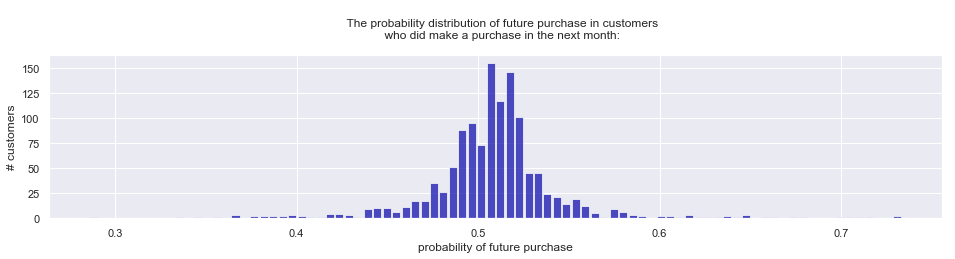

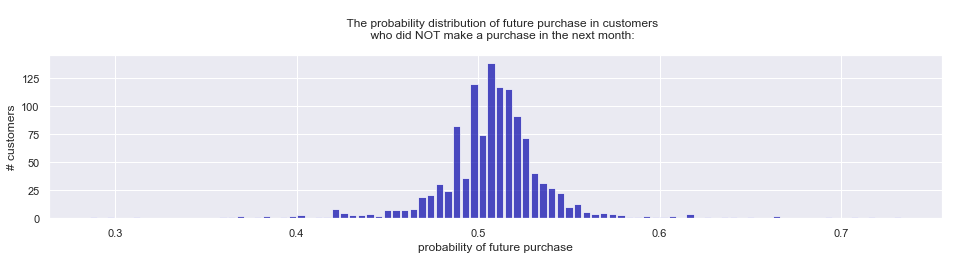

In [32]:
y_test_correct_value = y_test.reset_index(drop=True)

plt.figure()
plt.title(
    """
    The probability distribution of future purchase in customers
    who did make a purchase in the next month:
    """
)
plt.hist(
    x=y_test_pred[y_test_correct_value == 1]['prediction_1'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85
)
plt.xlabel('probability of future purchase')
plt.ylabel('# customers')
plt.show()

plt.figure()
plt.title(
    """
    The probability distribution of future purchase in customers
    who did NOT make a purchase in the next month:
    """
)
plt.hist(
    x=y_test_pred[y_test_correct_value == 0]['prediction_1'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85
)
plt.xlabel('probability of future purchase')
plt.ylabel('# customers')
plt.show()

A bigger difference in these charts means the model is more capable of differentiating between predicted classes.

In an ideal case we would like to have high bars on the right side of the x axis in the first chart. That would mean that the predicted probability of future purchase is high in most of the customers who really did make a future purchase. In the second chart it is exactly the other way around.
In this case we would like to have high bars around the value 0 because in this chart we are visualizing the probability of future purchase for customers who did NOT make a future purchase.

As we mentioned earlier, **we work with random values** in this template. Naturally, we cannot expect any miracles to happen here.

Another parameter which is useful when analyzing model performance is the **ROC curve** (Receiver Operating Characteristic). This curve shows the relation between False Positives and True Positives. A bigger area under the curve (**AUC**) is better (the ability to achieve a high True Positive Rate while keeping the False Positive Rate low).

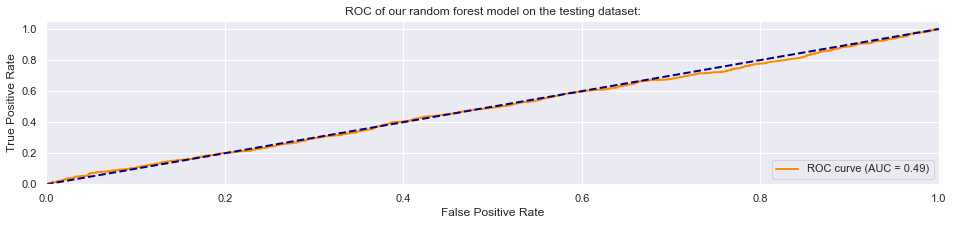

In [33]:
# methods for construction of ROC and AUC
from sklearn.metrics import auc, roc_curve

fpr, tpr, _ = roc_curve(y_test_correct_value, y_test_pred['prediction_1'])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of our random forest model on the testing dataset:')
plt.legend(loc="lower right")
plt.show()

#### 2.1.4 Model evaluation (validation dataset)

In order to make the experiment complete, we will do a quick check on the validation dataset (period 2). This dataset is composed on data gathered after the new year (the model is trained on data from autumn). We will use a similar approach as with the testing dataset, only this time we will not separate the data and we will not perform any further training.

In [34]:
# prepare the data
input_data_period2 = customers_period2_history[feature_selection]

customerids_period2_future = set(purchases_period2_future['customerid'])
future_buyers_period2 = customerids_period2_history.intersection(customerids_period2_future)
customers_period2_history['future_buyer'] = customers_period2_history['customerid'].apply(
    lambda customerid: 1 if customerid in future_buyers_period2 else 0
)

output_data_period2 = customers_period2_history['future_buyer']

# test the model
validation_prediction = model_randomForest.predict_proba(input_data_period2)
validation_probability = pd.DataFrame({
    'prediction_0': validation_prediction[:, 0],
    'prediction_1': validation_prediction[:, 1]
})

Let's do the same visualization as before:

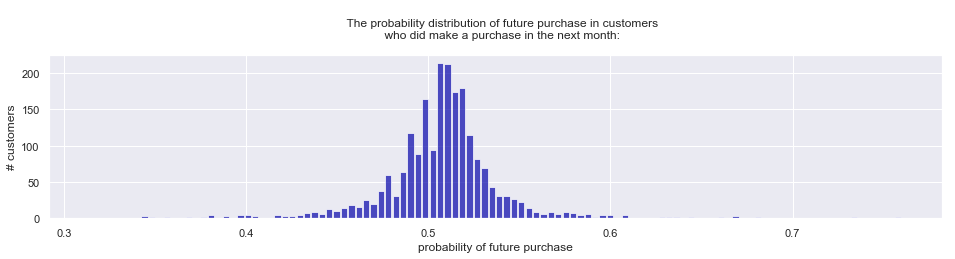

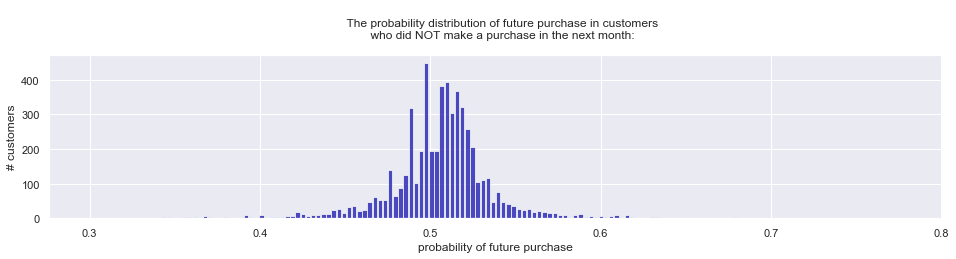

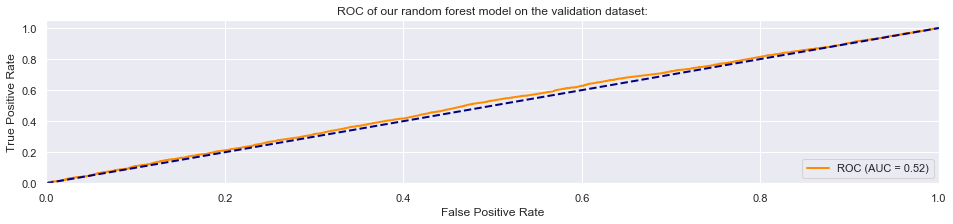

In [35]:
validation_correct_value = output_data_period2.reset_index(drop=True)

plt.figure()
plt.title(
    """
    The probability distribution of future purchase in customers
    who did make a purchase in the next month:
    """
)
plt.hist(
    x=validation_probability[validation_correct_value == 1]['prediction_1'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85
)
plt.xlabel('probability of future purchase')
plt.ylabel('# customers')
plt.show()

plt.figure()
plt.title(
    """
    The probability distribution of future purchase in customers
    who did NOT make a purchase in the next month:
    """
)
plt.hist(
    x=validation_probability[validation_correct_value == 0]['prediction_1'],
    bins='auto',
    color='#0504aa',
    alpha=0.7,
    rwidth=0.85
)
plt.xlabel('probability of future purchase')
plt.ylabel('# customers')
plt.show()



fpr, tpr, _ = roc_curve(validation_correct_value, validation_probability['prediction_1'])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of our random forest model on the validation dataset:')
plt.legend(loc="lower right")
plt.show()

It's quite clear that our model works randomly on the dummy data no matter whether it's autumn or spring. Similar behavior could end up really badly if the model was trained on the real data and deployed. In such case it would be better to use a crystal ball instead. Another option would be to dig into the results and find the cause of the randomness. A good place to start is a brainstorming about the input features or set-up of model hyperparameters.

## What to do next

We hope this notebook has helped you. Do you have any ideas on how to improve it? Let us know and share it with your peers!

Are you struggling with AI? Contact us! You can reach us via our website
- https://www.pbi.ai/.

or social media
- facebook https://www.facebook.com/pbiai/
- LinkedIn https://www.linkedin.com/company/18178189/
- Twitter https://twitter.com/pbi_ai

In [36]:
end_time = datetime.now()
print('end_time:', end_time)
print('elapsed_time:', end_time - start_time)

end_time: 2019-12-12 18:25:38.620912
elapsed_time: 0:00:18.469166
